# Building Machine Learning Datasets

All machine learning problems begin with a dataset, and before we can perform any kind of inference on that dataset we must create/wrangle/build it. This is often the most time-consuming and hard part of a successful machine learning workflow. There is no single procedure here, as all data is different, although there are a few simple methods we can take to make a useful dataset.

We will be using data from a submitted Manuscript (Butterworth and Barnett-Moore 2020) which was a finalist in the [Unearthed, ExploreSA: Gawler Challenge](https://unearthed.solutions/u/competitions/exploresa). You can visit the [original repo here](https://github.com/natbutter/gawler-exploration)


In [67]:
import shapefile
import pandas as pd
import numpy as np
import scipy
from scipy import io
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [1]:
#Import libraries for data manipulations
import pandas as pd
import numpy as np
import random
import scipy
from scipy import io

#Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits import mplot3d
import matplotlib.mlab as ml
from cartopy.io.img_tiles import Stamen
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata
from matplotlib.path import Path
from matplotlib.patches import PathPatch

#Import libraries for tif, shapefile, and geodata manipulations
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape

#Import Machine Learning libraries
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


#Import libraries for multi-threading capabilities
#from dask import delayed,compute
#from dask.distributed import Client, progress
import time

In [2]:
#Define simple helper functions used in workflow

def coregPoint(point,data,region):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    tree = scipy.spatial.cKDTree(data)
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if indexes==len(data):
        return 'inf'
    else:
        return (indexes,dists)
    
#
def points_in_circle(circle, arr):
    '''
    A generator to return all points whose indices are within given circle.
    http://stackoverflow.com/a/2774284
    Warning: If a point is near the the edges of the raster it will not loop 
    around to the other side of the raster!
    '''
    i0,j0,r = circle

    for i in range(intceil(i0-r),intceil(i0+r)):
        ri = np.sqrt(r**2-(i-i0)**2)
        for j in range(intceil(j0-ri),intceil(j0+ri)):
            if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):
                yield arr[i][j]

#            
def intceil(x):
    return int(np.ceil(x))                                            

#
def coregRaster(point,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    i0=point[1]
    j0=point[0]
    r=region #In units of degrees
    pts_iterator = points_in_circle((i0,j0,region), data)
    pts = np.array(list(pts_iterator))
    #remove values outside the region which for there is no data (0.0).
    #print(pts)
    pts = pts[pts != 0.]
    if np.isnan(np.nanmean(pts)):
        #print(point,"nan")
        #pts=np.median(data)
        pts=-9999.
        #print("returning",pts)

    return(np.nanmean(pts))

#Make a function that can turn point arrays into a full meshgrid
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

#Define a function to read the netcdf files
def readnc(filename):
    tic=time.time()
    rasterfile=filename
    data = scipy.io.netcdf_file(rasterfile,'r')
    xdata=data.variables['lon'][:]
    ydata=data.variables['lat'][:]
    zdata=np.array(data.variables['Band1'][:])

    toc=time.time()
    print(rasterfile, "in", toc-tic)
    print("spacing x", xdata[2]-xdata[1], "y", ydata[2]-ydata[1], np.shape(zdata),np.min(xdata),np.max(xdata),np.min(ydata),np.max(ydata))

    return(xdata,ydata,zdata)

#Define a function to find what polygon a point lives inside (speed imporivements can be made here)
def shapeExplore(point,shapes,recs,record):
    #'record' is the column index you want returned
    for i in range(len(shapes)):
        boundary = shapes[i]
        if Point((point.lon,point.lat)).within(shape(boundary)):
            return(recs[i][record])
    #if you have been through the loop with no result
    return(-9999.)

# Goal: Create a table of data containing "targets" and "predictor variables"

The targets in an ML context can be a simple binary 1 or 0, or could be some category. It is the "feature" of a dataset that we want to learn about!

The "predictor/feature variables" are the quatities that may have some causal relationship with the the targets.



### Deposit locations - mine and mineral occurances
The most important dataset for this workflow is the currently known locations of mineral occurences. Using the data we already know about these known-deposits we will build a model to predict where future occurences will be.

In [3]:
#Set the filename
mineshape="data/MinesMinerals/mines_and_mineral_occurrences_all.shp"

#Set shapefile attributes and assign
sf = shapefile.Reader(mineshape)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write into a dataframe fo easy use
df = pd.DataFrame(columns=fields, data=records)

In [4]:
#See what the dataframe looks like
df

,MINDEP_NO,DEP_NAME,REFERENCE,COMM_CODE,COMMODS,COMMOD_MAJ,COMM_SPECS,GCHEM_ASSC,DISC_YEAR,CLASS_CODE,...,NORTHING,ZONE,LONGITUDE,LATITUDE,SVY_METHOD,HORZ_ACC,SRCE_MAP,SRCE_CNTRE,COMMENTS,O_MAP_SYMB
0,5219,MOUNT DAVIES NO.2A,RB 65/80,Ni,Nickel,Ni,ELMT,,1893.0,OCCURRENCE,...,7112524.68,52,129.200549,-26.106335,Digitised,2000.0,500k meis,,,T\fe1
1,52,ONE STONE,MRR 138,Ni,Nickel,Ni,ELMT,Ni-Cr,1975.0,OCCURRENCE,...,7110551.56,53,132.775358,-26.107124,"Sourced from documents (PLANS, ENV, RB,etc)",500.0,71-385,,,T\si
2,8314,HINCKLEY RANGE,,Fe,Iron,Fe,ELMT,,1961.0,OCCURRENCE,...,7111381.52,52,129.101731,-26.116761,"Sourced from documents (PLANS, ENV, RB,etc)",500.0,,,,Mg
3,69,KALKA,RB 91/103,"V, ILM","Vanadium, Ilmenite",V,ELMT,Fe-V-Ti,1968.0,OCCURRENCE,...,7110521.49,52,129.116042,-26.124516,(DISUSED) Map Plot,100.0,1 MILE,mgt polygon on digital map,,Mg2
4,65,ECHIDNA,RB 91/103,Ni,Nickel,Ni,ELMT,Ni,1991.0,OCCURRENCE,...,7108531.53,53,132.770515,-26.125281,(DISUSED) Map Plot,20.0,50K GEOL,DH ECHIDNA PROSPECT,,LMb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8672,6937,YARINGA,RB 43/94,QTZE,Quartzite,QTZE,ROCK,,1956.0,OCCURRENCE,...,6066051.52,54,138.254441,-35.517924,Google Earth image,200.0,50k moc,fenced yard,,Eec
8673,4729,WELCHS,MSC #19,SCHT,Schist,SCHT,ROCK,,1930.0,OCCURRENCE,...,6066681.48,54,138.648619,-35.520578,Digital Image,20.0,50k topo,,,Elb
8674,4718,ARCADIAN,MSC #2,CLAY,Clay,CLAY,ROCK,,1921.0,DEPOSIT,...,6066561.56,54,138.660599,-35.521892,Digital Image,5.0,Plan 1951-0327,Pit,,Q
8675,1436,MCDONALD,MSC #7,Au,Gold,Au,ELMT,Au,1901.0,OCCURRENCE,...,6065991.54,54,138.436645,-35.522477,Google Earth image,200.0,50k moc,qz float,,qz


In [86]:
#We are building a model to target the Gawler region specifically.
#Load in the Gawler target region boundary
gawlshape="data/SA/SA_STATE_POLYGON_shp"
shapeRead = shapefile.Reader(gawlshape)
shapes  = shapeRead.shapes()

#Save the boundary xy pairs in arrays we will use throughout the workflow
xval = [x[0] for x in shapes[1].points]
yval = [x[1] for x in shapes[1].points]

### Set the commodity we want to target

In [6]:
commname='Mn'

In [7]:
#Pull our all the occurences of the commodity and go from there
comm=df[df['COMM_CODE'].str.contains(commname)]
comm=comm.reset_index(drop=True)
print("Shape of "+ commname, comm.shape)

#Can make simple subsets of the data here as needed
#commsig=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.COX_CLASS == "Olympic Dam Cu-U-Au"]
#comm=comm[(comm.lon<max(xval)) & (comm.lon>min(xval)) & (comm.lat>min(yval)) & (comm.lat<max(yval))]

#Can save subset to a file
#comm.to_csv("copper-deposits.csv")

Shape of Mn (115, 43)


In [59]:
comm

,MINDEP_NO,DEP_NAME,REFERENCE,COMM_CODE,COMMODS,COMMOD_MAJ,COMM_SPECS,GCHEM_ASSC,DISC_YEAR,CLASS_CODE,...,NORTHING,ZONE,LONGITUDE,LATITUDE,SVY_METHOD,HORZ_ACC,SRCE_MAP,SRCE_CNTRE,COMMENTS,O_MAP_SYMB
0,8488,WESTERN SPUR,Env 3959,"Fe, Mn","Iron, Manganese",Fe,ELMT,,1981.0,PROSPECT,...,6693381.50,54,139.179436,-29.877637,"Sourced from documents (PLANS, ENV, RB,etc)",50.0,,near hole VP 2,,Nww
1,4184,WILKOWIE HUT,Env 3959,Mn,Manganese,Mn,ELMT,,1980.0,OCCURRENCE,...,6669627.24,54,138.808767,-30.086296,Google Earth image,20.0,,,,Q
2,4221,DEPOT SPRINGS EAST,MSC #85,Mn,Manganese,Mn,ELMT,,1949.0,OCCURRENCE,...,6629681.53,54,138.752281,-30.445684,Google Earth image,200.0,250k meis,pit?,1.7km E of Depot Springs,dw
3,8350,JUBILEE,RB 26/111,Mn,Manganese,Mn,ELMT,,1949.0,OCCURRENCE,...,6619531.54,54,138.530506,-30.533225,"Sourced from documents (PLANS, ENV, RB,etc)",200.0,plan 50-471,,"plan 50-471, MR 91, pp 205",dw
4,8349,STUART CREEK,RB 26/111,Mn,Manganese,Mn,ELMT,,1949.0,OCCURRENCE,...,6616651.50,54,138.887019,-30.565479,Google Earth image,200.0,,dark o/c,"Mining review 091, pp 205.",dw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,254,TUMBY SOUTH,Bull 37,"Cu, Mn","Copper, Manganese",Cu,ELMT,,1899.0,OCCURRENCE,...,6200974.46,53,136.059715,-34.327929,GPS Standalone Navigational,10.0,59-91,Stephen Shaft,,TQr
111,533,CUTTLEFISH,MSC #19,Mn,Manganese,Mn,ELMT,Mn-(P),1897.0,OCCURRENCE,...,6041551.48,54,138.016821,-35.733084,GPS Standalone Navigational,10.0,,adit,"sample # 54561, Fe-rich o/c,",Nni
112,1644,NEALES FLAT,RB 56/127,Mn,Manganese,Mn,ELMT,Mn,1962.0,OCCURRENCE,...,6208721.50,54,139.250036,-34.250155,Google Earth image,50.0,Plans FO1035 and S03399,rough centre of MC,,go
113,5031,ROCK VALLEY,RB 61/121,"Fe, Mn","Iron, Manganese",Fe,ELMT,Fe-Mn,1961.0,OCCURRENCE,...,6190251.47,53,135.905480,-34.425866,"Sourced from documents (PLANS, ENV, RB,etc)",50.0,,near hole Rock Valley RD 1,,dw


## Wrangle the geophysical and geological datasets
Each geophysical dataset could offer instight into various commodities. Here we load in the pre-processed datasets and prepare them for further manipulations, data-mining, and machine learning.

### Resistivity xyz data

In [70]:
#Read in the data
data_res=pd.read_csv("data/AusLAMP_MT_Gawler_25.xyzr",
                     sep=',',header=0,names=['lat','lon','depth','resistivity'])
data_res

,lat,lon,depth,resistivity
0,-27.363931,128.680796,-25.0,2.0007
1,-27.659362,128.662322,-25.0,1.9979
2,-27.886602,128.647965,-25.0,1.9948
3,-28.061394,128.636833,-25.0,1.9918
4,-28.195844,128.628217,-25.0,1.9885
...,...,...,...,...
11003,-35.127716,142.399588,-25.0,2.0079
11004,-35.230939,142.408396,-25.0,2.0084
11005,-35.365124,142.419903,-25.0,2.0085
11006,-35.539556,142.434958,-25.0,2.0076


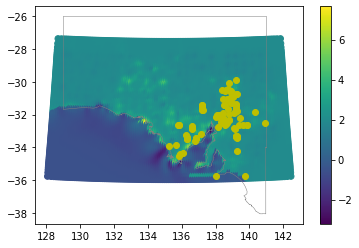

In [130]:
im=plt.scatter(data_res.lon,data_res.lat,c=data_res.resistivity)
plt.plot(xval,yval,'grey',linewidth=0.5,label='SA')
plt.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
plt.colorbar(im)

### Faults and dykes vector polylines

In [69]:
#Get fault data neo
faultshape="data/Faults/Faults.shp"
shapeRead = shapefile.Reader(faultshape)
shapes  = shapeRead.shapes()
Nshp    = len(shapes)

faultsNeo=[]
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsNeo.append([j[0],j[1]])
faultsNeo=np.array(faultsNeo)
p
faultsNeo

array([[133.46269605, -27.41825034],
       [133.46770683, -27.42062991],
       [133.4723624 , -27.42259841],
       ...,
       [138.44613353, -35.36560605],
       [138.44160669, -35.36672662],
       [138.43805501, -35.36793484]])

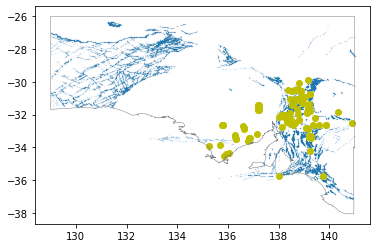

In [131]:
plt.plot(faultsNeo[:,0],faultsNeo[:,1],'.',markersize=0.1)
plt.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
plt.plot(xval,yval,'grey',linewidth=0.5,label='SA')

### Netcdf formatted raster grids

In [46]:
#Define a function to read the netcdf files
def readnc(filename):
    tic=time.time()
    rasterfile=filename
    data = scipy.io.netcdf_file(rasterfile,'r')
    xdata=data.variables['lon'][:]
    ydata=data.variables['lat'][:]
    zdata=np.array(data.variables['Band1'][:])

    toc=time.time()
    print("Loaded", rasterfile, "in", f'{toc-tic:.2f}s')
    print("Spacing x", f'{xdata[2]-xdata[1]:.2f}', "y", f'{ydata[2]-ydata[1]:.2f}', np.shape(zdata),np.min(xdata),np.max(xdata),np.min(ydata),f'{np.max(ydata):.2f}')

    return(xdata,ydata,zdata)

In [47]:
#TODO: Should be cleaned up and put into dictionary or similar.
#For now, reading individual datasets is fine
x1,y1,z1 = readnc("data/sa-dem.nc")
x2,y2,z2 = readnc("data/sa-mag-tmi.nc")
x3,y3,z3 = readnc("data/sa-grav.nc")

Loaded data/sa-dem.nc in 0.02s
Spacing x 0.01 y 0.01 (1208, 1201) 129.005 141.005 -38.065 -25.99
Loaded data/sa-mag-tmi.nc in 0.01s
Spacing x 0.01 y 0.01 (1208, 1201) 129.005 141.005 -38.065 -25.99
Loaded data/sa-grav.nc in 0.01s
Spacing x 0.01 y 0.01 (1208, 1201) 129.005 141.005 -38.065 -25.99


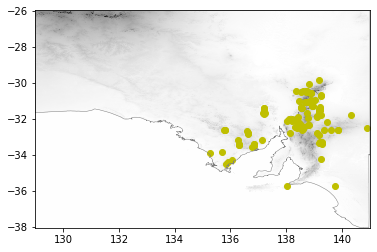

In [132]:
plt.pcolormesh(x1,y1,z1,cmap='Greys',shading='auto')
plt.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
plt.plot(xval,yval,'grey',linewidth=0.5,label='SA')

### Categorical Geology in vector polygons

In [48]:
#Archean basement geology
geolshape=shapefile.Reader("data/Archaean_Early_Mesoprterzoic_polygons_shp/geology_archaean.shp")

recsArch   = geolshape.records()
shapesArch  = geolshape.shapes()

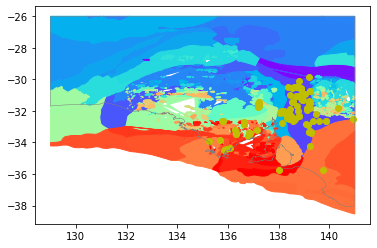

In [133]:
color = plt.cm.rainbow(np.linspace(0, 1, len(shapesArch)))
for i,c in enumerate(color): #, range(len(shapesArch)):
    boundary = shapesArch[i].points
    xs = [x for x, y in shapesArch[i].points]
    ys = [y for x, y in shapesArch[i].points]
    plt.fill(xs,ys,c=c)
    
plt.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
plt.plot(xval,yval,'grey',linewidth=0.5,label='SA')

## Take a moment to appreciate the various methods you have used just to load the data!

Now, we need to assign the values of each of these geophyiscal datasets (predictor variables) to the target class (i.e. mineral deposit locations). 
The assumption being that the occurnece of some mineral deposit (e.g. Cu) is a function of x1, x2, x3, x4, x5, x6. 
Where the Resitivity is x1, the distance to a Neoprotezoic fault is x2, the value of DEM, magnetic TMI, and Gravity is x3, x4, and x5, and the geologica basement unit name is x6.

# Part 2 - Spatial data mining of datasets

### Select the commodity and geophysical features to use 
Edit *commname* above and turn these labels on/off as required. 
Generally run data mining with all labels. 
Then can turn these features on/off before running ML if needed.

In [21]:
lons=['lon','lat']
reslabels = [     
'res-25',
'res-77',
'res-136',
'res-201',
'res-273',
'res-353',
'res-442',
'res-541',
'res-650',  
'res-772',
'res-907',
'res-1056',
'res-1223',
'res-1407',
'res-1612',
'res-1839',
'res-2092',
'res-2372',
'res-2683',
'res-3028',
'res-3411',
'res-3837',    
'res-4309',
'res-4833',
'res-5414',
'res-6060',
'res-6776',
'res-7572',
'res-8455',
'res-9435',
'res-10523',
'res-11730',
'res-13071',
'res-14559',
'res-16210',
'res-18043',   
'res-20078',
'res-22337',
'res-24844',
'res-27627',
'res-30716',
'res-34145',
'res-37951',
'res-42175',
'res-46865',
'res-52070',
'res-57847',
'res-64261',
'res-71379',
'res-79281',
'res-88052',
'res-97788',
'res-108595',
'res-120590',
'res-133905',
'res-148685',
'res-165090',
'res-183300',
'res-203513',
'res-225950',
'res-250854',
'res-278498',
'res-309183'
]
  
faultlabels=[
    "neoFaults",
    "archFaults",
    "gairFaults"
]

numerical_features=reslabels+faultlabels+[
"aster1-AlOH-cont",
"aster2-AlOH",
"aster3-FeOH-cont",
"aster4-Ferric-cont",
"aster5-Ferrous-cont",
"aster6-Ferrous-index",
"aster7-MgOH-comp",
"aster8-MgOH-cont",
"aster9-green",
"aster10-kaolin",
"aster11-opaque",
"aster12-quartz",
"aster13-regolith-b3",
"aster14-regolith-b4",
"aster15-silica",
"base16",
"dem17",
"dtb18",
"mag19-2vd",
"mag20-rtp",
"mag21-tmi",
"rad22-dose",
"rad23-k",
"rad24-th",
"rad25-u",
"grav26"
]

categorical_features=[
'archean27',
'geol28',
'random'
]

### Generate the non-deposit dataset

This step is important. There are numerous ways to generate our non-deposit set, each with different benefits and trade-offs.
The randomisation of points throughout *some* domain appears to be robust. But you must think, is this domain a reasonable estimation of "background" geophysics/geology? Why are you picking these locations as non-deposits? Will they be over/under-representing actual deposits? Will they be over/under-representing actual non-deposits?

Change the lows, highs, and sizes as desired. And enforce the points are with some confinement area if needed.
A good place to start is within the spatial extent of the known deposits/commodity.

In [24]:
#Generate "non-deposit" points within the same spatial domains as deposits (e.g. on land, or in the gawler, or in SA).
#We may want to train and test just over the regions that the grids are valid.
#So we can crop the known deposits to the extent of the grids.

polgonshape=shapefile.Reader("SA-DATA/SA/SA_STATE_POLYGON_shp.shp")
#polgonshape=shapefile.Reader("SA-DATA/GCAS_Boundary/GCAS_Boundary.shp)
shapesPoly  = polgonshape.shapes()

#Now make a set of "non-deposits" using a random location within our exploration area
lats_rand=np.random.uniform(low=min(df.LATITUDE), high=max(df.LATITUDE), size=len(comm.LATITUDE))
lons_rand=np.random.uniform(low=min(df.LONGITUDE), high=max(df.LONGITUDE), size=len(comm.LONGITUDE))

#And enforce the random points are within our the shapefile boudary
#Probably more efficent ways to do this for larger datasets. Fine for now.
boundary=shapesPoly[1]
for i,_ in enumerate(lats_rand):
    while not Point((lons_rand[i],lats_rand[i])).within(shape(boundary)):
            lats_rand[i]=random.uniform(min(df.LATITUDE), max(df.LATITUDE))
            lons_rand[i]=random.uniform(min(df.LONGITUDE), max(df.LONGITUDE))
            
print("Produced", len(lats_rand),len(lons_rand), "latitude-longitude pairs for non-deposits.")

Produced 115 115 latitude-longitude pairs for non-deposits.


In [25]:
#Save the SA polygon for plotting
xvalsa = [x[0] for x in shapesPoly[1].points]
yvalsa = [x[1] for x in shapesPoly[1].points]

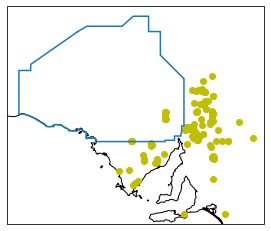

In [68]:
#Quick plot of where commodity deposit data is and generated non-deposit data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.margins(0.05) # 5% padding to the map boundary so we can see the true extent nicely

ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
#ax.plot(lons_rand,lats_rand,marker='.',linestyle='',color='k')
plt.plot(xval,yval,label='Gawler')

plt.show()

### Define function which performs coregistering/data-mining

In [27]:
def coregLoop(sampleData):
    '''
    Define a function to coregister the grids and perform the spatial data mining.
    
    Requires list of lat and lon, will return the value at that point for all the hardcoded grids
    sampleData=[lat,lon]
    
    Returns array of parameters in the form:
    [lat, lon, param1, param2,...., param92,randomValue]
    
    TODO: Hadrcoded grids currently defined globally. Apply function to pass in grids for finer control.
    '''
    
    lat=sampleData[0]
    lon=sampleData[1]
    #Set the search space over which to sample the geophysical grid
    #Units are in same unit as source grids
    region=1 
    #Set the search sapce to sample the resitivity layers
    region2=100

    #Get the closest Resitivity indexes to the point
    idx,dist=coregPoint([lon,lat],lonlatres,region2)
    
    #Get the distance to the faults from the point
    _,dist=coregPoint([lon,lat],faultsNeo,region2)
    _,dist2=coregPoint([lon,lat],faultsArch,region2)
    _,dist3=coregPoint([lon,lat],faultsGair,region2)

    #Get the Numerical data indexes of the geophys at the point
    xloc1=(np.abs(np.array(x1) - lon).argmin())
    yloc1=(np.abs(np.array(y1) - lat).argmin())
    xloc2=(np.abs(np.array(x2) - lon).argmin())
    yloc2=(np.abs(np.array(y2) - lat).argmin())
    xloc3=(np.abs(np.array(x3) - lon).argmin())
    yloc3=(np.abs(np.array(y3) - lat).argmin())
    xloc4=(np.abs(np.array(x4) - lon).argmin())
    yloc4=(np.abs(np.array(y4) - lat).argmin())
    xloc5=(np.abs(np.array(x5) - lon).argmin())
    yloc5=(np.abs(np.array(y5) - lat).argmin())
    xloc6=(np.abs(np.array(x6) - lon).argmin())
    yloc6=(np.abs(np.array(y6) - lat).argmin())
    xloc7=(np.abs(np.array(x7) - lon).argmin())
    yloc7=(np.abs(np.array(y7) - lat).argmin())
    xloc8=(np.abs(np.array(x8) - lon).argmin())
    yloc8=(np.abs(np.array(y8) - lat).argmin())
    xloc9=(np.abs(np.array(x9) - lon).argmin())
    yloc9=(np.abs(np.array(y9) - lat).argmin())
    xloc10=(np.abs(np.array(x10) - lon).argmin())
    yloc10=(np.abs(np.array(y10) - lat).argmin())
    xloc11=(np.abs(np.array(x11) - lon).argmin())
    yloc11=(np.abs(np.array(y11) - lat).argmin())
    xloc12=(np.abs(np.array(x12) - lon).argmin())
    yloc12=(np.abs(np.array(y12) - lat).argmin())
    xloc13=(np.abs(np.array(x13) - lon).argmin())
    yloc13=(np.abs(np.array(y13) - lat).argmin())
    xloc14=(np.abs(np.array(x14) - lon).argmin())
    yloc14=(np.abs(np.array(y14) - lat).argmin())
    xloc15=(np.abs(np.array(x15) - lon).argmin())
    yloc15=(np.abs(np.array(y15) - lat).argmin())
    xloc16=(np.abs(np.array(x16) - lon).argmin())
    yloc16=(np.abs(np.array(y16) - lat).argmin())
    xloc17=(np.abs(np.array(x17) - lon).argmin())
    yloc17=(np.abs(np.array(y17) - lat).argmin())
    xloc18=(np.abs(np.array(x18) - lon).argmin())
    yloc18=(np.abs(np.array(y18) - lat).argmin())
    xloc19=(np.abs(np.array(x19) - lon).argmin())
    yloc19=(np.abs(np.array(y19) - lat).argmin())
    xloc20=(np.abs(np.array(x20) - lon).argmin())
    yloc20=(np.abs(np.array(y20) - lat).argmin())
    xloc21=(np.abs(np.array(x21) - lon).argmin())
    yloc21=(np.abs(np.array(y21) - lat).argmin())
    xloc22=(np.abs(np.array(x22) - lon).argmin())
    yloc22=(np.abs(np.array(y22) - lat).argmin())
    xloc23=(np.abs(np.array(x23) - lon).argmin())
    yloc23=(np.abs(np.array(y23) - lat).argmin())
    xloc24=(np.abs(np.array(x24) - lon).argmin())
    yloc24=(np.abs(np.array(y24) - lat).argmin())
    xloc25=(np.abs(np.array(x25) - lon).argmin())
    yloc25=(np.abs(np.array(y25) - lat).argmin())
    xloc26=(np.abs(np.array(x26) - lon).argmin())
    yloc26=(np.abs(np.array(y26) - lat).argmin())

    
    #Numerical data values
    z1val=coregRaster([xloc1,yloc1],z1,region)
    z2val=coregRaster([xloc2,yloc2],z2,region)
    z3val=coregRaster([xloc3,yloc3],z3,region)
    z4val=coregRaster([xloc4,yloc4],z4,region)
    z5val=coregRaster([xloc5,yloc5],z5,region)
    z6val=coregRaster([xloc6,yloc6],z6,region)
    z7val=coregRaster([xloc7,yloc7],z7,region)
    z8val=coregRaster([xloc8,yloc8],z8,region)
    z9val=coregRaster([xloc9,yloc9],z9,region)
    z10val=coregRaster([xloc10,yloc10],z10,region)
    z11val=coregRaster([xloc11,yloc11],z11,region)
    z12val=coregRaster([xloc12,yloc12],z12,region)
    z13val=coregRaster([xloc13,yloc13],z13,region)
    z14val=coregRaster([xloc14,yloc14],z14,region)
    z15val=coregRaster([xloc15,yloc15],z15,region)
    z16val=coregRaster([xloc16,yloc16],z16,region)
    z17val=coregRaster([xloc17,yloc17],z17,region)
    z18val=coregRaster([xloc18,yloc18],z18,region)
    z19val=coregRaster([xloc19,yloc19],z19,region)
    z20val=coregRaster([xloc20,yloc20],z20,region)
    z21val=coregRaster([xloc21,yloc21],z21,region)
    z22val=coregRaster([xloc22,yloc22],z22,region)
    z23val=coregRaster([xloc23,yloc23],z23,region)
    z24val=coregRaster([xloc24,yloc24],z24,region)
    z25val=coregRaster([xloc25,yloc25],z25,region)
    z26val=coregRaster([xloc26,yloc26],z26,region)
    
    #Append all the values to an array to return
    #Return dummys for categorical data for now
    vals=np.array([lon,lat])
    vals=np.append(vals,f[:,idx,3])
    vals=np.append(vals,
                   [
                    dist,dist2,dist3,
                    z1val,z2val,z3val,
                    z4val,z5val,z6val,
                    z7val,z8val,z9val,
                        z10val,z11val,z12val,
                    z13val,z14val,z15val,
                    z16val,z17val,z18val,
                    z19val,z20val,z21val,
                    z22val,z23val,z24val,
                    z25val,z26val,
                    -9999.,-9999.
                   ])
    #Append a random choice of 999 or -999 to benchmark ML
    coregMap=np.append(vals,[random.choice([-999, 999])])
    
    #Return the data
    return(coregMap)
    


## Run spatial mining of known deposits and "non-deposits"
Must be re-run on each commodity change. Can be saved and just loaded in if data has already been generated.

In [28]:
#Load in co-registerd training data
training_data=pd.read_csv("ML-DATA/training_data-"+commname+".csv",header=0)

#Or if that does not exist run next two cells....

In [29]:
#Interrogate the data associated with deposits

#Coregloop takes about 0.07s per call
#shapeExplore takes about 1.7s per call

tic=time.time()
deps1=[]
for row in comm.itertuples():
    lazy_result = coregLoop([row.LATITUDE,row.LONGITUDE])
    #lazy_result = delayed(coregLoop)([row.LATITUDE,row.LONGITUDE])
    deps1.append(lazy_result)
    
vec1=pd.DataFrame(np.squeeze(deps1),columns=lons+numerical_features+categorical_features)
vec1['deposit'] = 1 #Add the "depoist category flag"

toc=time.time()
print("Time deposits:", toc-tic, " seconds")
tic=time.time()

#Interrogate the data associated with randomly smapled points to use as counter-examples
deps0=[]
for lat,lon in zip(lats_rand,lons_rand):
    lazy_result = coregLoop([lat,lon])
    #lazy_result = delayed(coregLoop)([lat,lon])
    deps0.append(lazy_result)
    
vec2=pd.DataFrame(np.squeeze(deps0),columns=lons+numerical_features+categorical_features)
vec2['deposit'] = 0 #Add the "non-deposit category flag"

toc=time.time()
print("Time non-deposits:", toc-tic, " seconds")


#Combine the datasets
training_data = pd.concat([vec1, vec2], ignore_index=True)

tic=time.time()

#Add the categorical shapefile data
training_data['geol28']=training_data.apply(shapeExplore, args=(shapesGeol,recsGeol,1), axis=1)
training_data['archean27']=training_data.apply(shapeExplore, args=(shapesArch,recsArch,-1), axis=1)

toc=time.time()
print("Time geology:", toc-tic, " seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


Time deposits: 15.536046981811523  seconds
Time non-deposits: 15.219344139099121  seconds
Time geology: 40.391884565353394  seconds


In [297]:
#And save the training data out to a file
training_data.to_csv("ML-DATA/training_data-"+commname+".csv")

In [298]:
#Use this to clean rows from ML if particular data does not have exisitng data and would dilute the models too mcuh
# training_data['badsum']=(training_data == -9999.).astype(int).sum(axis=1)
# (training_data == -9999).astype(int).sum(axis=1).value_counts()
# #If many of the points have no data, drop them
# indexNames = training_data[ training_data['badsum'] > 10 ].index
# training_data.drop(indexNames, inplace=True)
# #training_data.drop(columns=['badsum'], inplace=True)
# #indexNames = training_data[ training_data['17dem'] == 0 ].index
# #training_data.drop(indexNames , inplace=True)
# #Save number of deps/non-deps
# lennon=len(training_data.deposit[training_data.deposit==0])
# lendep=len(training_data.deposit[training_data.deposit==1])

# training_data


In [30]:
#Save number of deps/non-deps, to be used for counting later
lennon=len(training_data.deposit[training_data.deposit==0])
lendep=len(training_data.deposit[training_data.deposit==1])
print(lennon,lendep)

#And look at the coregistered training data we have data-mined!
training_data

115 115


,lon,lat,res-25,res-77,res-136,res-201,res-273,res-353,res-442,res-541,...,mag21-tmi,rad22-dose,rad23-k,rad24-th,rad25-u,grav26,archean27,geol28,random,deposit
0,139.179436,-29.877637,2.2135,2.2916,2.3263,2.3432,2.3547,2.3644,2.3725,2.3779,...,-103.815964,53.314350,1.326607,13.133085,77.592484,1.656689,19214,8602,999.0,1
1,138.808767,-30.086296,2.3643,2.4819,2.5282,2.5482,2.5608,2.5713,2.5803,2.5875,...,-203.493454,57.424988,1.505081,10.301062,65.972046,-12.404812,19218,6658,999.0,1
2,138.752281,-30.445684,2.1141,2.1535,2.1710,2.1804,2.1879,2.1954,2.2035,2.2124,...,-167.319275,94.660133,2.568490,20.143124,85.115166,-6.649049,19218,15524,999.0,1
3,138.530506,-30.533225,2.2234,2.3151,2.3644,2.3946,2.4182,2.4402,2.4621,2.4846,...,-131.731750,73.580902,2.218921,14.252978,68.107780,-11.395281,19218,15524,-999.0,1
4,138.887019,-30.565479,2.1982,2.2647,2.2899,2.2987,2.3022,2.3038,2.3039,2.3022,...,-194.104736,70.939156,1.907848,10.630255,73.486282,-1.273882,19218,13222,-999.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,140.950913,-36.818736,2.0303,2.0433,2.0518,2.0586,2.0650,2.0716,2.0787,2.0865,...,64.354500,31.400856,0.577390,6.478987,53.581688,-12.427198,19222,5028,-999.0,0
226,139.584019,-33.121195,2.0452,2.0671,2.0715,2.0635,2.0485,2.0289,2.0052,1.9775,...,-613.181885,52.888771,1.724605,9.917326,48.059807,-11.312914,19218,15524,-999.0,0
227,134.221487,-28.522637,2.0157,2.0031,1.9811,1.9584,1.9370,1.9161,1.8942,1.8699,...,123.653641,55.559757,0.828879,15.572678,62.832291,-24.688011,18446,6658,999.0,0
228,131.427746,-30.738339,1.9768,1.9636,1.9494,1.9326,1.9126,1.8891,1.8617,1.8299,...,114.935860,34.257481,0.830566,6.841074,50.776741,-15.348145,18012,6684,-999.0,0


## Run spatial mining of gawler target data
Only needs to be done once. Each commodity uses this same dataset for targetting. The values of the grid are used to predict whatever commodity is run. Depending on target resolution and whether using parallel versions, can take a good amount of time. 

In [31]:
#Load in target data
target_data=pd.read_csv("ML-DATA/target_data.csv",header=0)

#OR run the next 5 cells....

In [ ]:
################ RUN FROM HERE ONCE (or use the HPC versions for high-res) ##########################
#Make a regularly spaced grid here for use in making a probablilty map later
lats_reg=np.linspace(min(yval),max(yval),10)
lons_reg=np.linspace(min(xval),max(xval),10)
#lats_reg=np.arange(min(yval),max(yval)+0.0100,0.0100)
#lons_reg=np.arange(min(xval),max(xval)+0.0100,0.0100)

sampleData=[]
for lat in lats_reg:
    for lon in lons_reg:
            sampleData.append([lat, lon])
            
print(np.size(sampleData))

In [ ]:
#Run the data-mining/coregistration
gridgawler=[]
tic=time.time()
for geophysparams in sampleData:
    #lazy_result = delayed(coregLoop)(geophysparams)
    lazy_result = coregLoop(geophysparams)
    gridgawler.append(lazy_result)
print("appended, now running...")

#c=compute(gridgawler)
toc=time.time()

print("Time taken:", toc-tic, " seconds")

In [ ]:
#Clean up the output file
target_data=pd.DataFrame(np.squeeze(gridgawler),columns=lons+numerical_features+categorical_features)

In [ ]:
#Add the categorical shapefile data
target_data['geol28']=target_data.apply(shapeExplore, args=(shapesGeol,recsGeol,1), axis=1)
target_data['archean27']=target_data.apply(shapeExplore, args=(shapesArch,recsArch,-1), axis=1)

In [ ]:
#Save out the data, and no need to run the co-registration again.
target_data.to_csv("target_data.csv",index=False)

################## RUN TO HERE ONCE #########################

In [32]:
#Look at the target data
#Should be in the same form as the training data WITHOUT the information of whether it is a deposit or non-deposit.
target_data

,lon,lat,res-25,res-77,res-136,res-201,res-273,res-353,res-442,res-541,...,mag20-rtp,mag21-tmi,rad22-dose,rad23-k,rad24-th,rad25-u,grav26,archean27,geol28,random
0,131.000009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
1,131.010009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
2,131.020009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,-999.0
3,131.030009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
4,131.040009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374161,137.970009,-27.344987,1.9917,1.9870,1.9831,1.9793,1.9749,1.9697,1.9647,1.9629,...,60.714424,77.071075,-9999.0,-9999.0,-9999.0,-9999.0,-36.425686,14548,2030,-999.0
374162,137.980009,-27.344987,1.9917,1.9870,1.9831,1.9793,1.9749,1.9697,1.9647,1.9629,...,58.152508,72.153748,-9999.0,-9999.0,-9999.0,-9999.0,-35.383732,14548,2030,-999.0
374163,137.990009,-27.344987,1.9924,1.9882,1.9849,1.9819,1.9785,1.9746,1.9707,1.9681,...,56.024078,66.960632,-9999.0,-9999.0,-9999.0,-9999.0,-34.756775,14548,2030,999.0
374164,138.000009,-27.344987,1.9924,1.9882,1.9849,1.9819,1.9785,1.9746,1.9707,1.9681,...,53.722004,61.110107,-9999.0,-9999.0,-9999.0,-9999.0,-34.204567,14548,2030,999.0


# Part 3 - Machine learning model

Now we have a fully data-mined, coregistered set of geophysical features. Both for training with known information about our deposits classification labels, and also a target set, we can build and apply the Machine Learning model classifier.

In [33]:
#First, we can check some details about the data. 
#Simple check whether at least MOST of the geophysical parameters have a reasonable value associated with them.
[print(training_data.columns[i],j) for i,j in enumerate(training_data.median())]
#If any of these score -9999.0 it is recommended to remove from that column from analysis
#You can do this, by now "commenting out" the layer in cell 27.

lon 138.24976824878848
lat -31.4234139
res-25 2.0562500000000004
res-77 2.07275
res-136 2.0737
res-201 2.0729
res-273 2.0686
res-353 2.0707
res-442 2.06045
res-541 2.0584
res-650 2.0572999999999997
res-772 2.0549999999999997
res-907 2.0544000000000002
res-1056 2.0513
res-1223 2.05735
res-1407 2.0737
res-1612 2.0917000000000003
res-1839 2.0865
res-2092 2.0808999999999997
res-2372 2.0644
res-2683 2.01925
res-3028 2.0089
res-3411 2.0092999999999996
res-3837 1.9667
res-4309 1.98135
res-4833 1.9901499999999999
res-5414 2.0079000000000002
res-6060 2.1113999999999997
res-6776 2.1632
res-7572 2.252
res-8455 2.3027499999999996
res-9435 2.35195
res-10523 2.4196
res-11730 2.4535
res-13071 2.4711499999999997
res-14559 2.5052
res-16210 2.4838
res-18043 2.4543999999999997
res-20078 2.41535
res-22337 2.3192500000000003
res-24844 2.3199
res-27627 2.33305
res-30716 2.2951
res-34145 2.3369999999999997
res-37951 2.372
res-42175 2.3846499999999997
res-46865 2.4406499999999998
res-52070 2.4587
res-57847 2.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### ML Classification
This is where the ML classifier is defined. We can substitue our favourite ML technique here, and tune model variables as desired. The default choices are recommended for the Gawler region.

In [34]:
#Create the 'feature vector' and a 'target classification vector'
features=training_data[numerical_features+categorical_features]
targets=training_data.deposit

#Create the ML classifier with numerical and categorical data
#Scale, and replace missing values
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=-9999., strategy='median')),
    ('scaler', StandardScaler())])

#Encode categorical data and fill missing values with default 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Combine numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=1))])


In [35]:
#You can apply weighting to the model here. 
#We find manual selction (i.e with sound geological reasoning) of deposits is probably more robust 
#than applying arbitrary weighting of class labels. 
#Nevertheless, we can do this if desired by uncommenting and tweaking  the following.

weights=np.ones(len(training_data))
weightcount=0

#Algorithm for setting weight values, point by point
# for i,row in enumerate(training_data[training_data.deposit==1].itertuples()):
#     xloc1=(np.abs(np.array(comm.LONGITUDE) - row.lon).argmin())
#     if comm.loc[xloc1].SIZE_VAL=="Locally Significant":
#         weights[i]=2
#     elif comm.loc[xloc1].SIZE_VAL=="Significant to SA":
#         weights[i]=4
#     elif comm.loc[xloc1].SIZE_VAL=="Significant to Australia":
#         weights[i]=8
#     elif comm.loc[xloc1].SIZE_VAL=="World-wide Significance":
#         weights[i]=16
#     else:
#         #Else keep the weight at 1
#         weightcount+=1
#         weights[i]=0
#         continue
        

    

Tranining the Clasifier...
Done RF. Now scoring...
RF 10-fold cross validation Scores: [0.95652174 0.86956522 1.         0.86956522 0.91304348 0.91304348
 0.7826087  0.86956522 0.82608696 0.69565217]
SCORE Mean: 0.87 STD: 0.08 



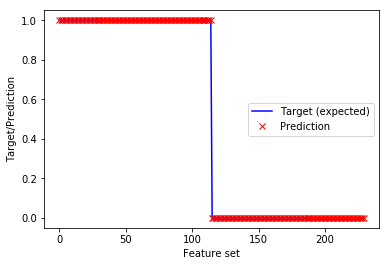

In [36]:
print('Tranining the Clasifier...')
rf.fit(features,targets,**{'classifier__sample_weight': weights})

print("Done RF. Now scoring...")
scores = cross_val_score(rf, features,targets, cv=10)

print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend(loc=7)

In [37]:
#Make a plot out the feature scores. 
#These are the important parameters that are correlated with the deposits.

ft_idx=[]
ft_lab=[]
all_idx=[]
all_lab=[]
all_dat=[]
#Just print the significant features above some threshold
for i,lab in enumerate(np.append(numerical_features,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))):
    all_dat.append([i,lab,rf.steps[1][1].feature_importances_[i]])
    all_lab.append(lab)
    all_idx.append(i)
    if rf.steps[1][1].feature_importances_[i] >1*np.median(rf.steps[1][1].feature_importances_): 
        ft_idx.append(i)
        ft_lab.append(lab)
        

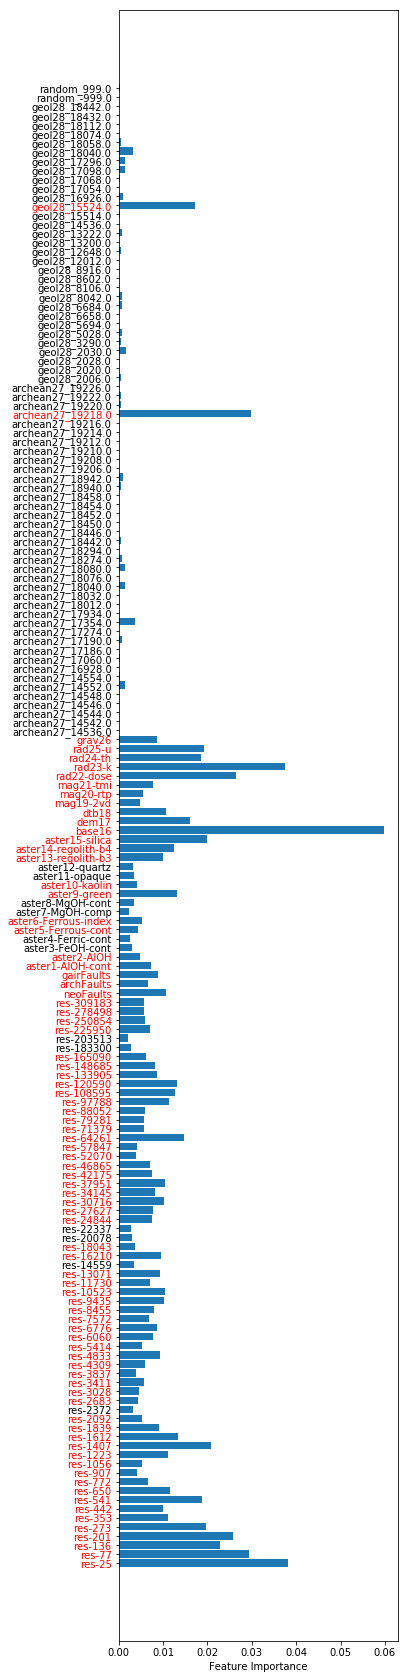

In [38]:
#And plot all the feature importances
#plt.plot(rf.steps[1][1].feature_importances_)

fig, ax = plt.subplots(figsize=(5,30))

ft_imps=rf.steps[1][1].feature_importances_
y_pos=np.arange(len(ft_imps))
ax.barh(y_pos,ft_imps,align='center')

ax.set_yticks(all_idx)
ax.set_yticklabels(all_lab)
ax.yaxis.label.set_color('red')
for i in ft_idx:
    ax.get_yticklabels()[i].set_color("red")

ax.set_xlabel('Feature Importance')

plt.show()

#plt.xticks([0,1,2,3,4,5,7,81,82,83,84,85,86])

RF...
Done RF


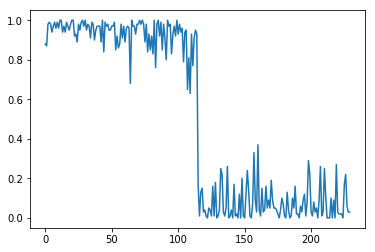

In [39]:
#Chec the probabilities at each of the deposit/non-deposit points
print('RF...')
pRF=np.array(rf.predict_proba(features))
print("Done RF")

plt.plot(pRF[:,1])

## Finally, apply the model to the grid

In [40]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(target_data[numerical_features+categorical_features]))
print("Done RF")

RF...
Done RF


In [41]:
#Create a meshgrid from our xyz list of points
gridX,gridY,gridZ=grid(target_data.lon, target_data.lat,pRF_map[:,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.


In [310]:
#Save the csv grid of targets
targetCu = {'Longitude': target_data.lon, 'Latitude': target_data.lat, 'Prediction': pRF_map[:,1]}
targetCu=pd.DataFrame(targetCu)
targetCu.to_csv('Targets-'+commname+'.csv',header=0,index=False)

<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname><urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>



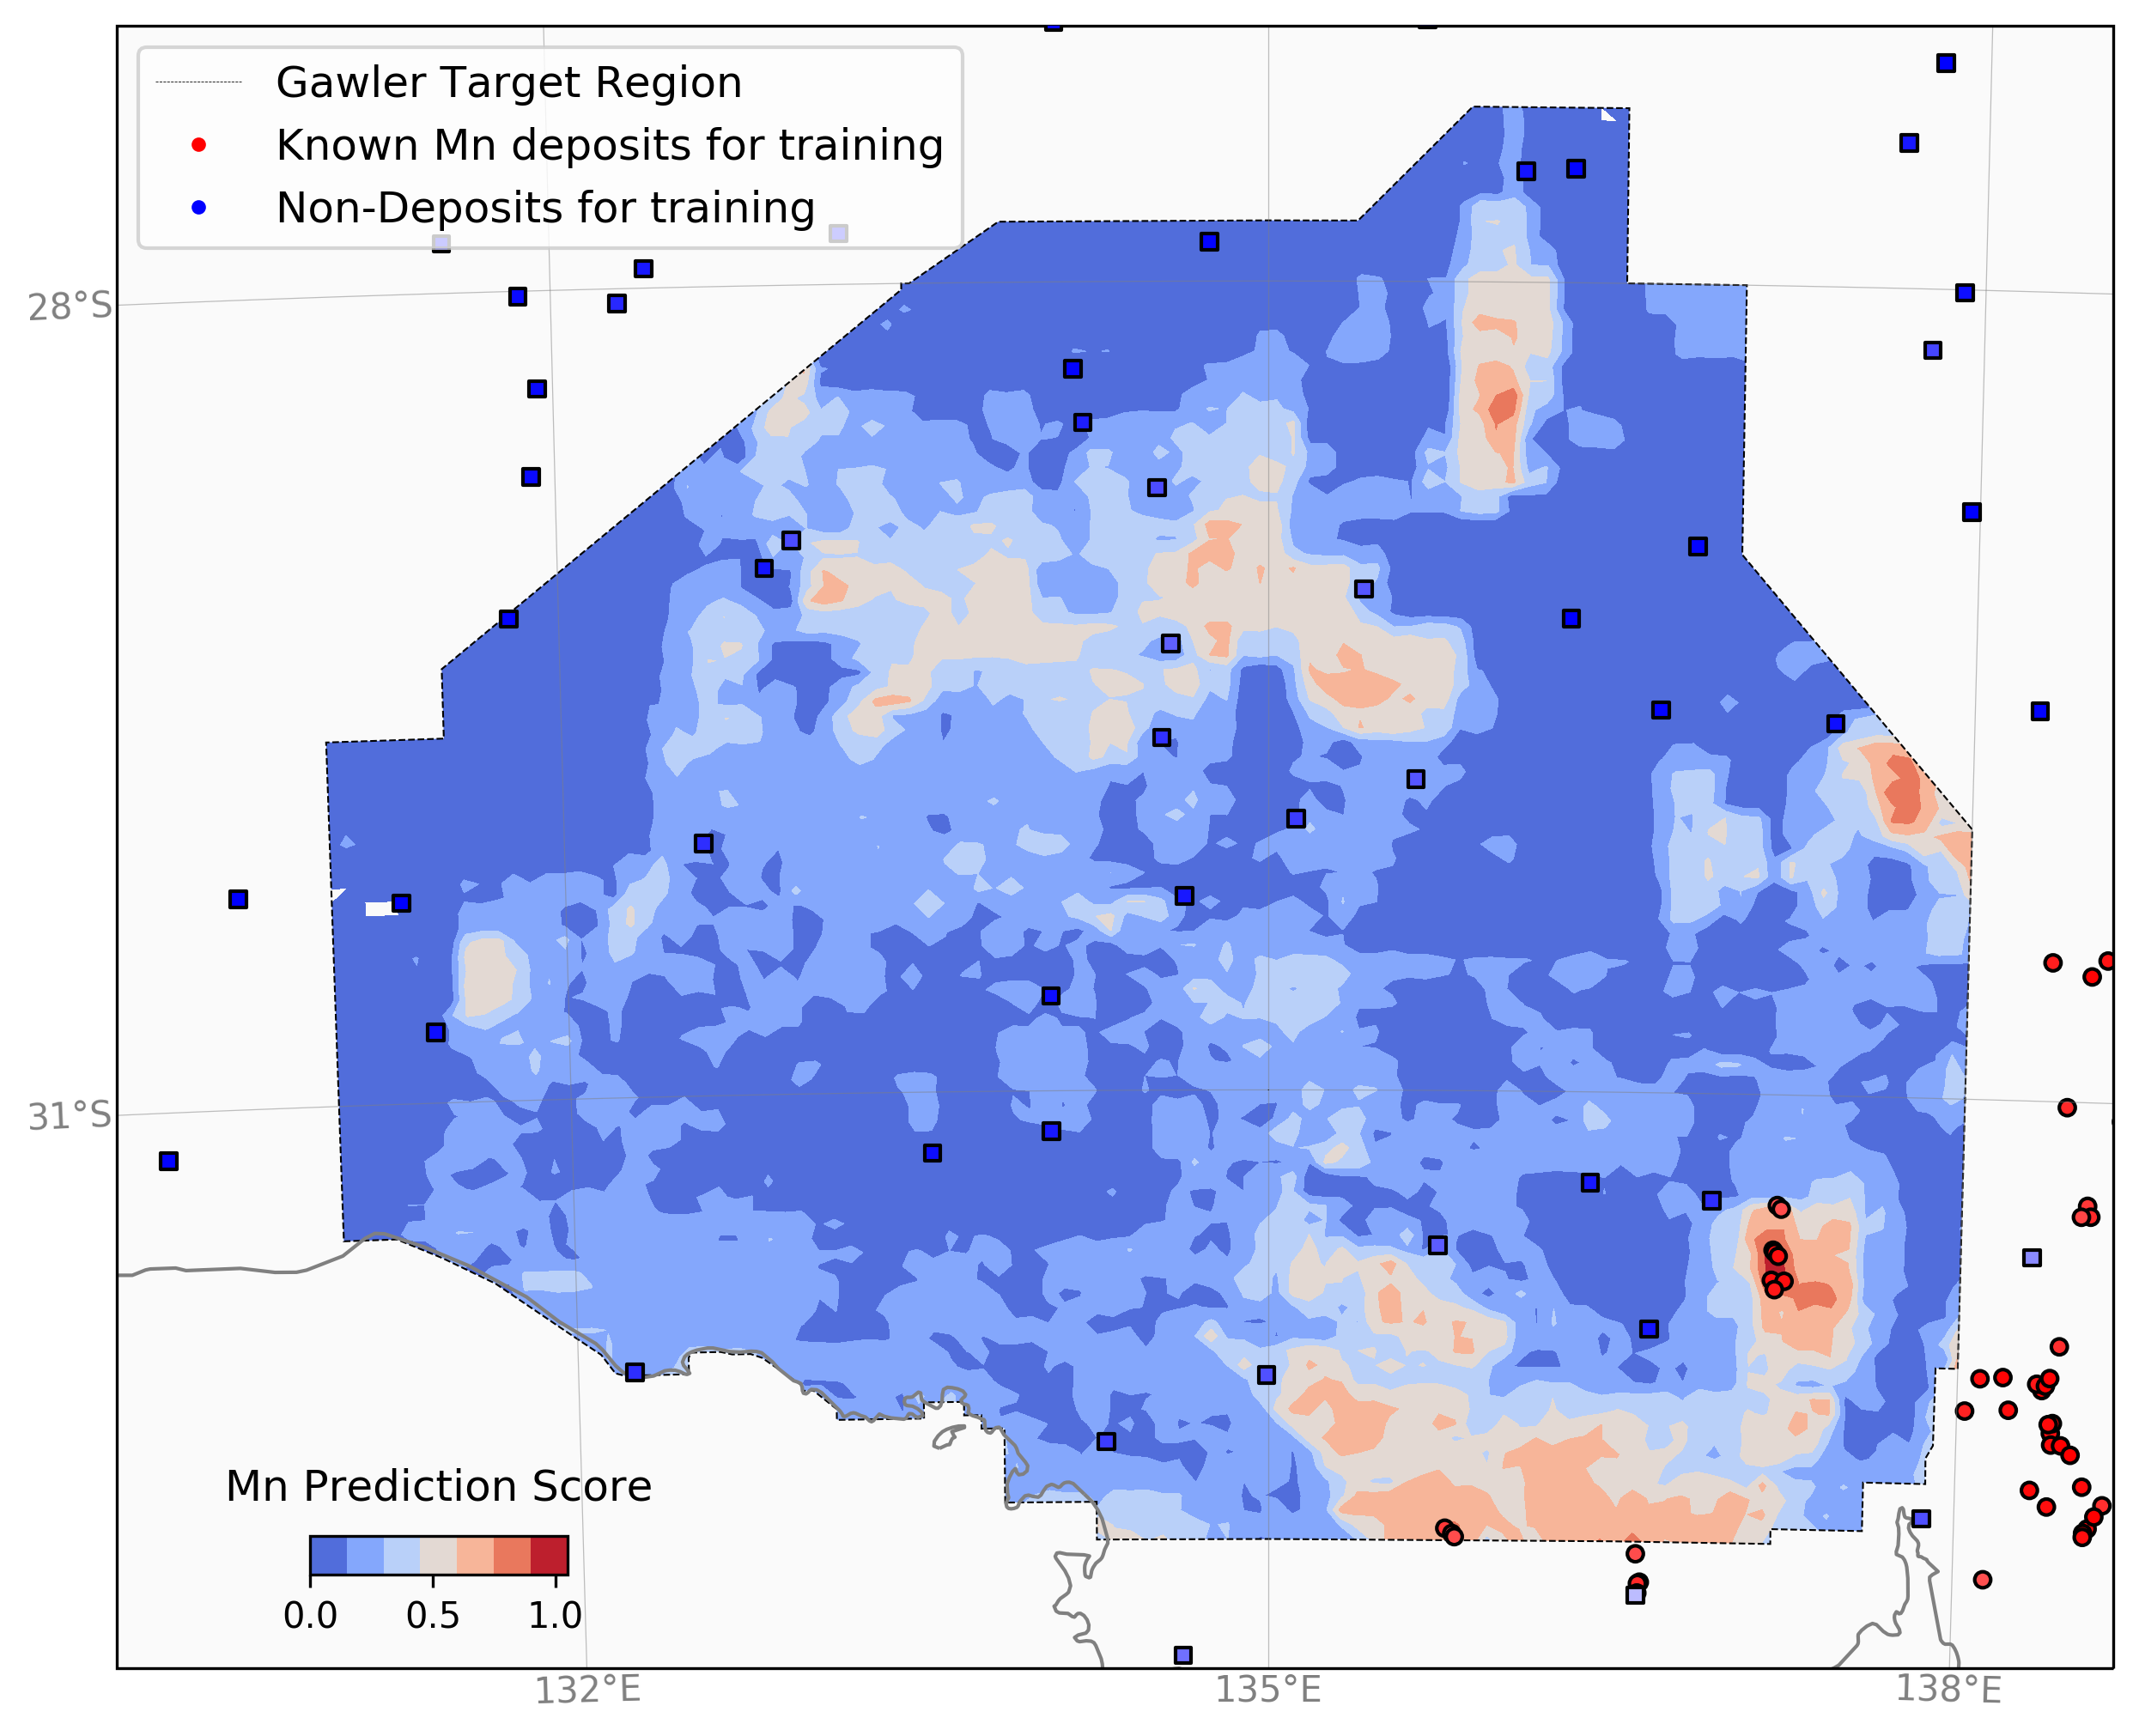

In [42]:
#Plot the final target map
fig = plt.figure(figsize=(10,10),dpi=300)

#Make a map projection to plot on.
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=135.0, central_latitude=-31.0))
       
#Set the extent of interest
img_extent = [min(df.LONGITUDE)+1.5,  max(df.LONGITUDE)-3.0, min(df.LATITUDE)+5,max(df.LATITUDE)-1]
ax.set_extent(img_extent)

#Put down a base map
ax.coastlines(resolution='10m', color='gray',)
tiler = Stamen('terrain-background')
mercator = tiler.crs
ax.add_image(tiler, 6)

#Make the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.3, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
#gl.xlines = False
gl.xlocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LONGITUDE))+1,np.ceil(max(df.LONGITUDE))-1,num=5)))
gl.ylocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LATITUDE))+1,np.ceil(max(df.LATITUDE))-1,num=5)))
gl.xlocator = mticker.FixedLocator([141,138,135,132,129])
gl.ylocator = mticker.FixedLocator([-38,-34,-31,-28,-26])
#gl.ylocator = mticker.FixedLocator(list(np.linspace(-28,-35,num=3)))
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#Create a patch of the gawler region where the data is
path=Path(list(zip(xval, yval)))
patch = PathPatch(path, facecolor='none',transform = ccrs.PlateCarree(),linestyle='--',linewidth=0.5)
plt.gca().add_patch(patch)

#Plot the main map
im=ax.contourf(gridX,gridY,gridZ,cmap=plt.cm.coolwarm,transform = ccrs.PlateCarree(),vmin=0,vmax=1)
#im = ax.imshow(gridZ, interpolation='bicubic', cmap=plt.cm.bwr,
#                origin='lower', extent=[np.min(gridX),np.max(gridX),np.min(gridY),np.max(gridY)],
#                clip_path=patch, clip_on=True,zorder=1,transform = ccrs.PlateCarree())
for c in im.collections:
    c.set_clip_path(patch)
    
# l5=ax.scatter(commall.LONGITUDE, commall.LATITUDE, 
#               edgecolor='k',s=10,marker='d', linewidths=0.5,label="",
#               c='r',cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=2,transform = ccrs.PlateCarree())

#Add the deposits coloured by their classification score
l4=ax.scatter(training_data.lon[training_data.deposit==0], training_data.lat[training_data.deposit==0],
               edgecolor='k',s=20,marker='s', linewidths=1,label="",
               c=pRF[lendep:,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=3,transform = ccrs.PlateCarree())

l3=ax.scatter(training_data.lon[training_data.deposit==1], training_data.lat[training_data.deposit==1], 
              edgecolor='k',s=20,marker='o', linewidths=1,label="",
              c=pRF[:lendep,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=2,transform = ccrs.PlateCarree())

#Plot the outline of the Gawler region
ax.plot(xval,yval,'k--',label='Gawler Target Region',linewidth=0.2)
ax.plot(0,0,'r.',label='Known '+commname+' deposits for training',zorder=3,transform = ccrs.PlateCarree())
ax.plot(0,0,'b.',label='Non-Deposits for training',zorder=3,transform = ccrs.PlateCarree())
#ax.plot(0,0,'rd',label='All other Au deposits (not used for training)',zorder=3,transform = ccrs.PlateCarree())

# ax.plot(xlons,xlats,'y-',label='Central Gawler Au Province',zorder=3,transform = ccrs.PlateCarree())
# ax.plot(xlons2,xlats2,'g-',label='Olympic IOCG Province',zorder=3,transform = ccrs.PlateCarree())

# ax.plot(xval,yval,'k--',label='Gawler Target Region',linewidth=0.5,zorder=2,transform = ccrs.PlateCarree())

# Add a map title, legend, colorbar
#plt.title('Known deposits and predictive map for Gawler region, SA')
ax.legend(loc=2,fontsize=12)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

#Make a Colorbar
# cbaxes = fig.add_axes([0.16, 0.27, 0.25, 0.015])
# cbar = plt.colorbar(l3, cax = cbaxes,orientation="horizontal")
# cbar.set_label(commname+' prediction')

cbaxes = fig.add_axes([0.20, 0.22, 0.1, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0.0,0.5,1])
# # #cbar.ax.set_xticklabels(['Medium','High'],fontsize=8)
cbar.set_label(commname+' Prediction Score', labelpad=10,fontsize=12)
cbar.ax.xaxis.set_label_position('top')

plt.show()